In [6]:
# Install required packages
!pip install torch torchvision matplotlib numpy tqdm

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import torchvision.transforms as transforms
from tqdm import tqdm
import time

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset for Chest X-Ray
class ChestXRayDataset(Dataset):
    def __init__(self, image_paths, labels, reports, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.reports = reports
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            img = Image.open(self.image_paths[idx]).convert('RGB')
            if self.transform:
                img = self.transform(img)
            label = self.labels[idx]
            report = self.reports[idx]
            return img, label, report
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            return None

# Load Chest X-Ray Dataset with extreme debugging
def load_chest_xray_dataset(data_dir):
    image_paths = []
    labels = []
    ground_truth_reports = []
    error_count = 0
    processed_files = []
    skipped_files = []

    report_templates = {
        0: ["Normal lung X-ray with clear fields."],
        1: ["Abnormal lung X-ray with pneumonia detected."]
    }

    print(f"Checking dataset in: {data_dir}")
    # Manual test of a sample Pneumonia file
    sample_pneumonia_path = "/content/drive/MyDrive/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg"  # Adjust if needed
    if os.path.exists(sample_pneumonia_path):
        try:
            img = Image.open(sample_pneumonia_path).convert('RGB')
            print(f"Manual test: Successfully loaded {sample_pneumonia_path}")
        except Exception as e:
            print(f"Manual test: Failed to load {sample_pneumonia_path}: {e}")
    else:
        print(f"Manual test: File not found: {sample_pneumonia_path}")

    for split in ['train', 'test', 'val']:
        split_dir = os.path.join(data_dir, split)
        if not os.path.exists(split_dir):
            print(f"Split directory not found: {split_dir}")
            continue
        for category in ['NORMAL', 'PNEUMONIA']:
            category_dir = os.path.join(split_dir, category)
            if os.path.exists(category_dir):
                print(f"Processing directory: {category_dir}")
                file_count = 0
                for img_name in os.listdir(category_dir):
                    path = os.path.join(category_dir, img_name)
                    processed_files.append(path)
                    print(f"Encountered file: {path}")
                    if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.jfif', '.JPG', '.JPEG', '.PNG', '.bmp', '.BMP')):
                        try:
                            img = Image.open(path).convert('RGB')
                            image_paths.append(path)
                            label = 1 if category == 'PNEUMONIA' else 0
                            labels.append(label)
                            ground_truth_reports.append(np.random.choice(report_templates[label]))
                            print(f"Successfully loaded {path} as {'Pneumonia' if label == 1 else 'Normal'}")
                            file_count += 1
                        except Exception as e:
                            print(f"Failed to load {path}: {e}")
                            error_count += 1
                    else:
                        skipped_files.append(f"{path} (unsupported extension: {img_name.split('.')[-1]})")
                        print(f"Skipping {path} (unsupported extension: {img_name.split('.')[-1]})")
                print(f"Found {file_count} valid images in {category_dir}")
            else:
                print(f"Category directory not found: {category_dir}")

    if not image_paths:
        raise ValueError("No images found in the dataset directory!")
    if labels.count(0) == 0 or labels.count(1) == 0:
        raise ValueError(f"Dataset contains only one class! Loaded {len(labels)} images, all Normal={labels.count(0)}, Pneumonia={labels.count(1)}. Processed files: {processed_files[:10]}... (total {len(processed_files)}). Skipped files: {skipped_files[:10]}... (total {len(skipped_files)})")

    print(f"Loaded {len(image_paths)} images. Errors: {error_count}")
    print(f"Label distribution: Normal={labels.count(0)}, Pneumonia={labels.count(1)}")
    if skipped_files:
        print(f"Skipped files: {skipped_files[:10]}... (total {len(skipped_files)})")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = ChestXRayDataset(image_paths, labels, ground_truth_reports, transform)
    return dataset, labels

# Load dataset
data_dir = "/content/drive/MyDrive/chest_xray"  # Confirm this path
try:
    dataset, all_labels = load_chest_xray_dataset(data_dir)
    print(f"Dataset size: {len(dataset)} samples")
except Exception as e:
    print(f"Failed to load dataset: {e}")
    exit()

# Split dataset with stratification
train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2, stratify=all_labels, random_state=42)
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
print(f"Train label distribution: Normal={sum(1 for i in train_idx if all_labels[i] == 0)}, Pneumonia={sum(1 for i in train_idx if all_labels[i] == 1)}")
print(f"Test label distribution: Normal={sum(1 for i in test_idx if all_labels[i] == 0)}, Pneumonia={sum(1 for i in test_idx if all_labels[i] == 1)}")

# Create DataLoaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# Define Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.reshape(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn_model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

# Training with loss tracking
start_time = time.time()
cnn_model.train()
train_losses = []
for epoch in range(5):
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    epoch_loss = 0
    for images, labels, _ in loop:
        if images is None or labels is None:
            continue
        images, labels = images.to(device), labels.to(device)
        optimizer_cnn.zero_grad()
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_cnn.step()
        epoch_loss += loss.item()
        train_losses.append(loss.item())
        loop.set_postfix(loss=loss.item())
    avg_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")


Streaming output truncated to the last 5000 lines.
Encountered file: /content/drive/MyDrive/chest_xray/train/PNEUMONIA/person1502_bacteria_3923.jpeg
Successfully loaded /content/drive/MyDrive/chest_xray/train/PNEUMONIA/person1502_bacteria_3923.jpeg as Pneumonia
Encountered file: /content/drive/MyDrive/chest_xray/train/PNEUMONIA/person1438_bacteria_3721.jpeg
Successfully loaded /content/drive/MyDrive/chest_xray/train/PNEUMONIA/person1438_bacteria_3721.jpeg as Pneumonia
Encountered file: /content/drive/MyDrive/chest_xray/train/PNEUMONIA/person1449_bacteria_3747.jpeg
Successfully loaded /content/drive/MyDrive/chest_xray/train/PNEUMONIA/person1449_bacteria_3747.jpeg as Pneumonia
Encountered file: /content/drive/MyDrive/chest_xray/train/PNEUMONIA/person1462_virus_2512.jpeg
Successfully loaded /content/drive/MyDrive/chest_xray/train/PNEUMONIA/person1462_virus_2512.jpeg as Pneumonia
Encountered file: /content/drive/MyDrive/chest_xray/train/PNEUMONIA/person1496_virus_2605.jpeg
Successfully loa

Epoch 1: 100%|██████████| 1177/1177 [05:05<00:00,  3.85it/s, loss=0.0104]


Epoch 1 average loss: 0.2273


Epoch 2: 100%|██████████| 1177/1177 [05:32<00:00,  3.55it/s, loss=0.0266]


Epoch 2 average loss: 0.1190


Epoch 3: 100%|██████████| 1177/1177 [05:33<00:00,  3.52it/s, loss=0.0981]


Epoch 3 average loss: 0.0821


Epoch 4: 100%|██████████| 1177/1177 [05:32<00:00,  3.54it/s, loss=0.000481]


Epoch 4 average loss: 0.0529


Epoch 5: 100%|██████████| 1177/1177 [05:41<00:00,  3.44it/s, loss=0.000117]

Epoch 5 average loss: 0.0174


Average validation loss: 0.3289
Training time: 1701.09 seconds
Generating predictions and reports...
y_test distribution: Normal=322, Pneumonia=855
y_pred distribution: Normal=277, Pneumonia=900
Sample y_test: [1 1 0 0 1 0 1 1 1 1]
Sample y_pred: [1 1 0 0 1 0 1 1 1 1]
Sample prediction probabilities (Pneumonia): [7.3671615e-01 9.9940479e-01 9.1049105e-06 1.8011991e-02 9.2240649e-01
 1.9241584e-04 9.9999654e-01 9.9964702e-01 9.9815959e-01 9.9994147e-01]
Confusion Matrix shape: (2, 2)
Confusion Matrix:
[[256  66]
 [ 21 834]]

Classification Report:
              precision    recall  f1-score   support

      Normal       0.92      0.80      0.85       322
   Pneumonia       0.93      0.98      0.95       855

    accuracy                           0.93      1177
   macro avg       0.93      0.89      0.90      1177
weighted avg       0.93      0.93      0.92      1177



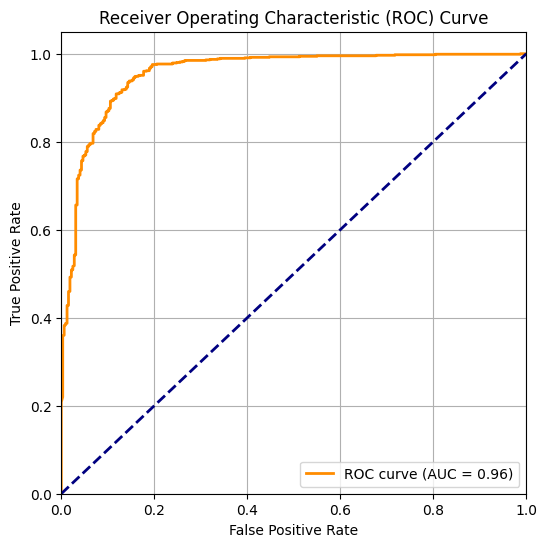

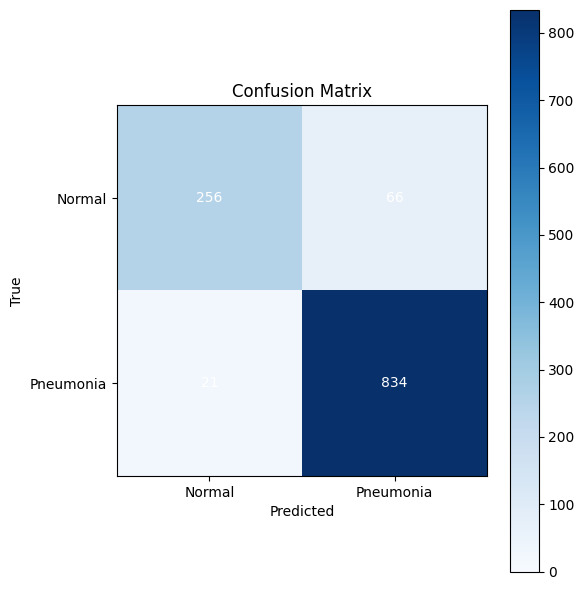

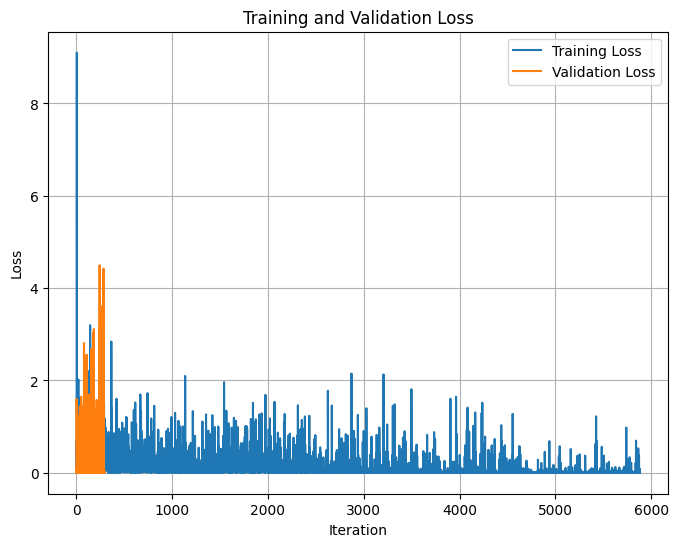

Accuracy: 0.93
Precision: 0.93, Recall (Sensitivity): 0.98, F1-Score: 0.95
Specificity: 0.80
AUC: 0.96


In [7]:
cnn_model.eval()
val_losses = []
with torch.no_grad():
    for images, labels, _ in test_loader:
        if images is None or labels is None:
            continue
        images, labels = images.to(device), labels.to(device)
        outputs = cnn_model(images)
        loss = criterion(outputs, labels)
        val_losses.append(loss.item())
avg_val_loss = np.mean(val_losses) if val_losses else 0
print(f"Average validation loss: {avg_val_loss:.4f}")

print(f"Training time: {time.time() - start_time:.2f} seconds")

# Predictions and Report Generation
cnn_model.eval()
y_test = []
y_pred = []
y_pred_proba = []  # For ROC curve
rpt_test = []
predicted_reports = []
print("Generating predictions and reports...")
with torch.no_grad():
    for images, labels, reports in test_loader:
        if images is None or labels is None:
            continue
        images = images.to(device)
        labels = labels.numpy()
        outputs = cnn_model(images).cpu().numpy()
        probs = torch.softmax(torch.tensor(outputs), dim=1).numpy()[:, 1]  # Probability of Pneumonia (class 1)
        preds = outputs.argmax(axis=1)
        y_test.extend(labels)
        y_pred.extend(preds)
        y_pred_proba.extend(probs)
        rpt_test.extend(reports)
        predicted_reports.extend([
            "Normal lung X-ray with clear fields." if pred == 0 else "Abnormal lung X-ray with pneumonia detected."
            for pred in preds
        ])

y_test = np.array(y_test)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

# Debug prints
print(f"y_test distribution: Normal={list(y_test).count(0)}, Pneumonia={list(y_test).count(1)}")
print(f"y_pred distribution: Normal={list(y_pred).count(0)}, Pneumonia={list(y_pred).count(1)}")
print(f"Sample y_test: {y_test[:10]}")
print(f"Sample y_pred: {y_pred[:10]}")
print(f"Sample prediction probabilities (Pneumonia): {y_pred_proba[:10]}")

# Evaluation Metrics
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
print(f"Confusion Matrix shape: {cm.shape}")
print(f"Confusion Matrix:\n{cm}")

if cm.size == 0 or cm.shape[0] < 2:
    print("Warning: Confusion matrix is invalid (likely single class). Check dataset or predictions.")
    precision, recall, f1, specificity = 0.0, 0.0, 0.0, 0.0
else:
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0, labels=[0, 1])
    accuracy = accuracy_score(y_test, y_pred)
    sensitivity = recall
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1]) if (cm[0, 0] + cm[0, 1]) > 0 else 0

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Pneumonia'], zero_division=0))

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Visualization
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=cm.max())
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks([0, 1], ['Normal', 'Pneumonia'])
plt.yticks([0, 1], ['Normal', 'Pneumonia'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='white')
plt.tight_layout()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Print Metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}, Recall (Sensitivity): {recall:.2f}, F1-Score: {f1:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"AUC: {roc_auc:.2f}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Assuming cnn_model and device are defined from your previous context
# Ensure cnn_model is loaded and device is set (e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))

def generate_radiology_report(image_path):
    # Load and preprocess single image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    try:
        img = Image.open(image_path).convert('RGB')
        img = transform(img).unsqueeze(0).to(device)
    except Exception as e:
        return f"Error loading image: {str(e)}. Please check the file path or format."

    # Predict
    cnn_model.eval()
    with torch.no_grad():
        output = cnn_model(img).cpu().numpy()
        probabilities = torch.softmax(torch.tensor(output), dim=1).numpy()[0]  # Softmax probabilities
        pred = output.argmax()  # Predicted class (0 or 1)
        confidence = probabilities[pred] * 100  # Confidence percentage

    # Generate report with varied templates and confidence
    normal_reports = [
        f"Normal lung X-ray with clear fields. Confidence: {confidence:.1f}%.",
        f"Healthy lung X-ray observed with no abnormalities. Confidence: {confidence:.1f}%.",
        f"Clear lung fields detected in X-ray. Confidence: {confidence:.1f}%."
    ]
    pneumonia_reports = [
        f"Abnormal lung X-ray with pneumonia detected. Confidence: {confidence:.1f}%.",
        f"Pneumonia indicated in lung X-ray with moderate severity. Confidence: {confidence:.1f}%.",
        f"Lung X-ray shows signs of pneumonia. Confidence: {confidence:.1f}%. Recommend further evaluation."
    ]

    # Select report based on prediction and confidence
    if pred == 0:
        report = normal_reports[np.random.randint(0, len(normal_reports))]
    else:
        # Add severity hint based on confidence
        if confidence < 70:
            report = f"Possible pneumonia detected in lung X-ray. \nLow confidence ({confidence:.1f}%). \nFurther review recommended."
        else:
            report = pneumonia_reports[np.random.randint(0, len(pneumonia_reports))]

    # Optional: Basic image intensity check (for context, not diagnosis)
    img_tensor = transform(Image.open(image_path).convert('RGB')).to(device)
    mean_intensity = torch.mean(img_tensor).item() * 255  # Scale back to 0-255 range
    report += f" Image mean intensity: {mean_intensity:.1f} (for reference)."

    return report

# Example usage
def simulate_report_generation():
    print("\n=== Radiology Report Generator ===")
    while True:
        user_input = input("Enter image path (or 'exit' to quit): ")
        if user_input.lower() == 'exit':
            print("Thank you for using the Radiology Report Generator!")
            break
        try:
            report = generate_radiology_report(user_input)
            print(f"Generated Report: {report}")
        except Exception as e:
            print(f"Error: {str(e)}. Please ensure the image path is valid.")

if __name__ == "__main__":
    simulate_report_generation()


=== Radiology Report Generator ===
Enter image path (or 'exit' to quit):  # Validation loop (optional) cnn_model.eval() val_losses = [] with torch.no_grad():     for images, labels, _ in test_loader:         if images is None or labels is None:             continue         images, labels = images.to(device), labels.to(device)         outputs = cnn_model(images)         loss = criterion(outputs, labels)         val_losses.append(loss.item()) avg_val_loss = np.mean(val_losses) if val_losses else 0 print(f"Average validation loss: {avg_val_loss:.4f}")  print(f"Training time: {time.time() - start_time:.2f} seconds")  # Predictions and Report Generation cnn_model.eval() y_test = [] y_pred = [] y_pred_proba = []  # For ROC curve rpt_test = [] predicted_reports = [] print("Generating predictions and reports...") with torch.no_grad():     for images, labels, reports in test_loader:         if images is None or labels is None:             continue         images = images.to(device)         lab